In [1]:

import torch
torch.set_printoptions(precision=10)

from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
import yaml
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import specific_radius_mfp_loader, plot_NMR

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


In [3]:
# load model 

# Choice 1: flexible model
model_path = Path(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/NewRepoNewDataOldCode/flexible_models_best_FP/r0_r2_FP_trial_1")
checkpoint_path = model_path / "checkpoints/epoch=35-all_inputs.ckpt"

# Choice  2: all-three nmr model
# model_path = Path(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/entropy_radius_exps_all_info/R0_to_R4_all_info_trial_1")
# checkpoint_path = model_path / "checkpoints/epoch=22-step=11408.ckpt"



hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)
max_radius = int(hparams['FP_choice'].split("_")[-1][1:])
print("max_radius: ", max_radius)
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
max_radius:  2


In [4]:

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


Using jaccard:  False


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [5]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [7]:
# len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

In [8]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [9]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename)

Oxypaeonidanin
COC1OC2(C)CC(=O)C3CC2(OC2OC(CO)C(O)C(O)C2O)C13COC(=O)c1ccc(O)cc1
10017.pt


In [10]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2(C)CC(=O)C3CC2(OC2OC(CO)C(O)C(O)C2O)C13COC(=O)c1ccc(O)cc1',
 'Oxypaeonidanin')

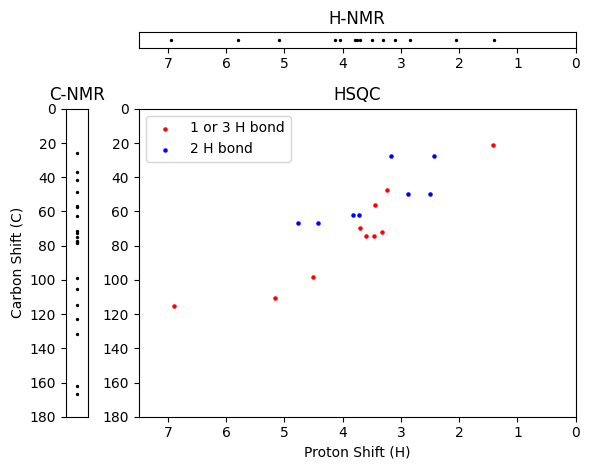

In [11]:


plot_NMR(hsqc, c_tensor, h_tensor)

In [12]:
import torch.nn.functional as F
import heapq

def retrieve_top_k_by_dir(dir, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()
    results = []
    for  ranker_f in sorted(os.listdir(dir), key=lambda x:int(x.split("_")[1].split(".")[0])):
    # for num_ranker_data, ranker_f in [(54,"FP_54.pt")]:
        # print(ranker_f)
        num_ranker_data = int(ranker_f.split("_")[1].split(".")[0])
        data = torch.load(os.path.join(dir, ranker_f)).to("cuda")
        query_products = (data @ query)
        values, indices = torch.topk(query_products,k=k)
        if len(results) == 0:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappush(results, (value, real_idx, data[idx].nonzero()))
        else:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappushpop(results, (value, real_idx, data[idx].nonzero()))    
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret

def retrieve_top_k_by_rankingset(data, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()

    results = []
    query_products = (data @ query)
    values, indices = torch.topk(query_products,k=k)
    
    for value, idx in zip(values, indices):
        results.append((value, idx, data[idx].nonzero()))
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret
        

In [13]:
smiles_and_names = pickle.load(open(f'/root/gurusmart/MorganFP_prediction/inference_data/hyunwoo_retrieval_data/SMILES_and_Names.pkl', 'rb'))

In [14]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/hyunwoo_retrieval_data/max_radius_{max_radius}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path).to("cuda")



In [15]:
def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor

# unpack_inputs(inputs)

# !!!
def compute_cos_sim(fp1, fp2):
    return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()

############################################### compound number: 464##############################################################
Ground Truth NMR


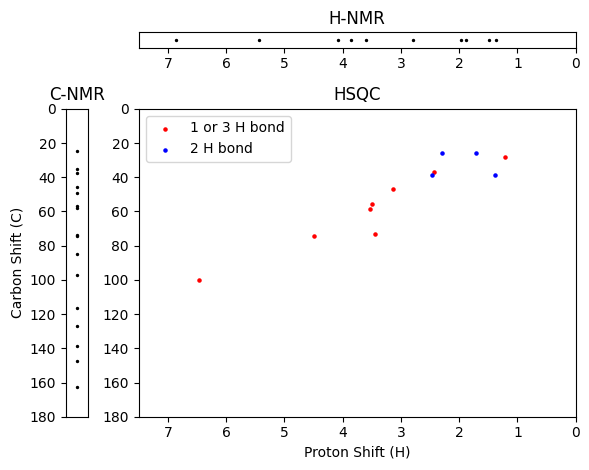

Chemical name (2R,3S,4aS,9aR,10R)-2,3,5,8-Tetrahydroxy-6,10-dimethoxy-3-methyl-1,3,4,4a,9a,10-hexahydro-9(2H)-anthracenone
Ground truth smiles COc1cc(O)c2c(c1O)C(OC)C1CC(C)(O)C(O)CC1C2=O


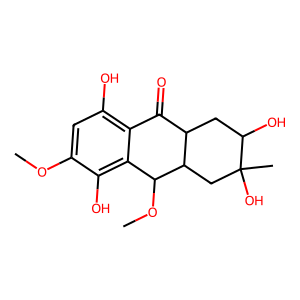

Prediction's cosine similarity to ground truth:  0.918462336063385
SMILES: COc1cc(O)c2c(c1O)C(OC)C1CC(C)(O)C(O)CC1C2=O
Name ['(2R,3S,4aS,9aR,10R)-2,3,5,8-Tetrahydroxy-6,10-dimethoxy-3-methyl-1,3,4,4a,9a,10-hexahydro-9(2H)-anthracenone', '4a-epi-9alpha-methoxydihydrodeoxybostrycin']


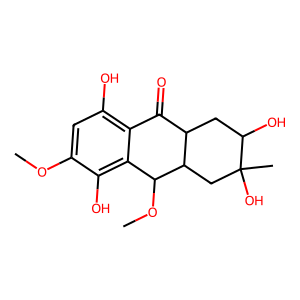

SMILES: COc1cc(O)c2c(c1O)C(O)C1CC(C)(O)C(O)CC1C2=O
Name ['1-deoxytetrahydrobostrycin, fusaquinone C', 'fusaquinon C', 'xylanthraquinone', 'fusaranthraquinone', '1-deoxytetrahydrobostrycin']


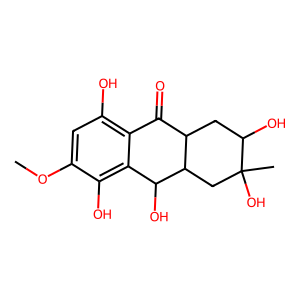

SMILES: COc1cc(O)c2c(c1O)C1OC3(C)CC1C(CC3O)C2=O
Name ['1,4,6-trihydroxy-2-methoxy-7-methyl-5,6,8,8a,9,10a-hexahydro-7,9-epoxyanthracen-10-one', 'fusaquinon A']


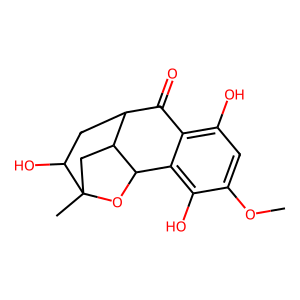

############################################### compound number: 751##############################################################
Ground Truth NMR


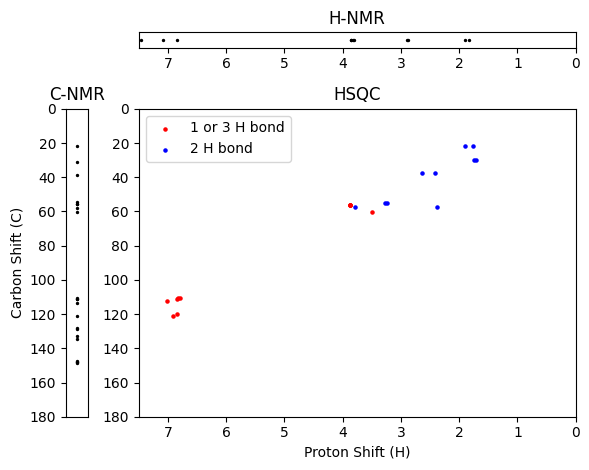

Chemical name 26503-67-3
Ground truth smiles COc1ccc(C2=C(c3ccc(OC)c(OC)c3)CN3CCCC3C2)cc1OC


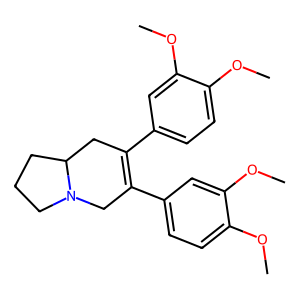

Prediction's cosine similarity to ground truth:  0.9155838489532471
SMILES: COc1ccc(C2=C(c3ccc(OC)c(OC)c3)CN3CCCC3C2)cc1OC
Name ['26503-67-3', 'Septicine']


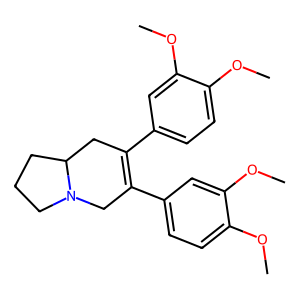

SMILES: COc1ccc(C2=C(c3ccc(OC)c(OC)c3)CN3CCCC3C2)cc1
Name ['6-(3,4-dimethoxyphenyl)-1,2,3,5,8,8a-hexahydro-7-(4-methoxyphenyl)indolizine', '(S)-(+)-hispidine', 'Hispidine']


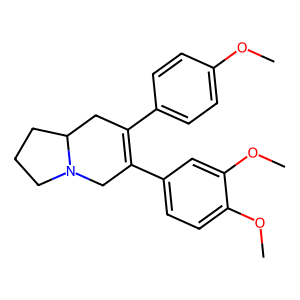

SMILES: COc1ccc(C2=C(c3ccc(OC)c(OC)c3)CC3CCCN3C2)cc1
Name ['O,O-dimethylphyllostemine', '(8Ar)-7-(3,4-Dimethoxyphenyl)-6-(4-Methoxyphenyl)-1,2,3,5,8,8A-Hexahydroindolizine']


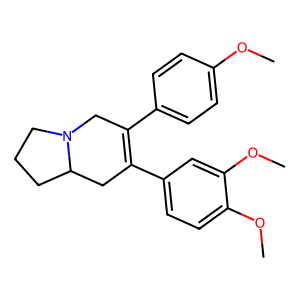

############################################### compound number: 696##############################################################
Ground Truth NMR


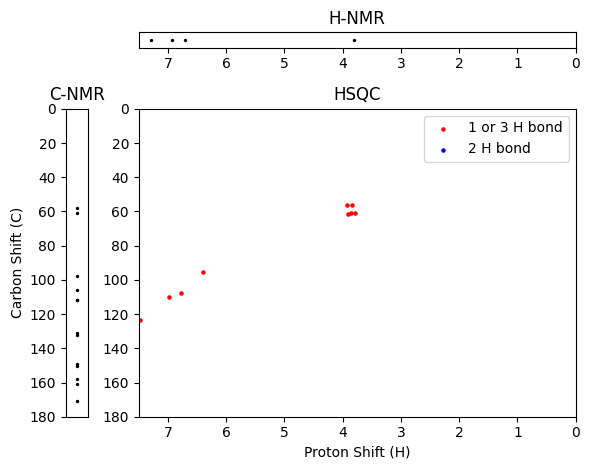

Chemical name 21315-67-3
Ground truth smiles COc1ccc(-c2cc(=O)c3c(O)cc(OC)c(OC)c3o2)c(OC)c1OC


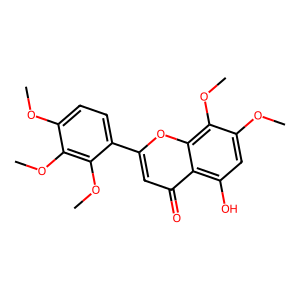

Prediction's cosine similarity to ground truth:  0.8875923752784729
SMILES: COc1ccc(-c2cc(=O)c3c(O)cc(OC)c(OC)c3o2)c(OC)c1OC
Name ['21315-67-3']


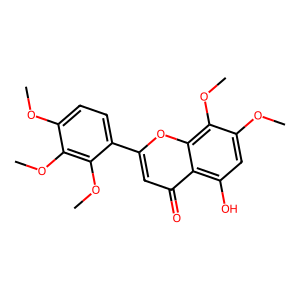

SMILES: COc1ccc(-c2cc(=O)c3c(O)cc(OC)c(OC)c3o2)cc1OC
Name ["5-hydroxy-3',4',7,8-tetramethoxyflavone", 'isosinensetin', '5-hydroxy-3?,4?,7,8-tetramethoxyflavone', "5-Hydroxy-7,8,3',4'-tetramethoxy-flavan", "3',4',7,8-Tetra-Me ether-3',4',5,7,8-Pentahydroxyflavone", '5-demethoxynobiletin', "5-hydroxy-7,8,3',4'-tetramethoxyflavone", '2-(3,4-dimethoxy-phenyl)-5-hydroxy-7,8-dimethoxy-chromen-4-one']


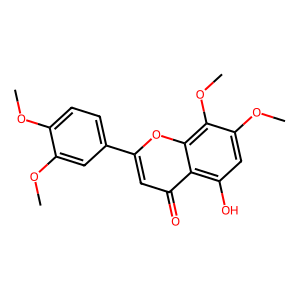

SMILES: COc1ccc(-c2cc(=O)c3c(O)cc(O)c(OC)c3o2)cc1OC
Name ["5,7-dihydroxy-8,3',4'-trimethoxyflavone", '2-(3,4-dimethoxy-phenyl)-5,7-dihydroxy-8-methoxy-chromen-4-one', 'Dimethoxy-nogonin', "3',4',8-Tri-Me ether-3',4',5,7,8-Pentahydroxyflavone", "3',4'-Dimethoxy-wogonin"]


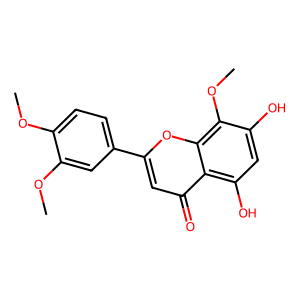

############################################### compound number: 2958##############################################################
Ground Truth NMR


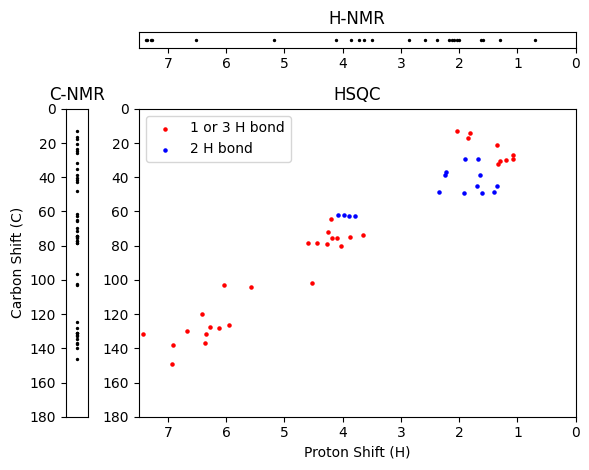

Chemical name 101224172
Ground truth smiles CC(C=C=C1C(C)(C)CC(O)CC1(C)O)=CC=CC(C)=CC=CC=C(C=O)C=CC=C(C)CCC12OC1(C)CC(OC1OC(CO)C(OC3OC(CO)C(O)C(O)C3O)C(O)C1O)CC2(C)C


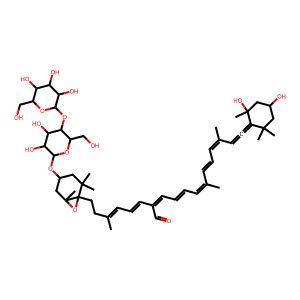

Prediction's cosine similarity to ground truth:  0.7527636289596558
SMILES: CC(C=C=C1C(C)(C)CC(O)CC1(C)O)=CC=CC(C)=CC=CC=C(C=O)C=CC=C(C)CCC12OC1(C)CC(OC1OC(CO)C(OC3OC(CO)C(O)C(O)C3O)C(O)C1O)CC2(C)C
Name ['P457', '101224172', 'Unnamed', "13'-cis-7',8'-dihydroneoxanthin-20'-al-3'-beta-lactoside"]


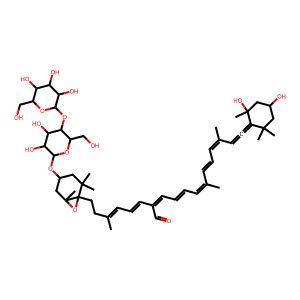

SMILES: CC(C=CC=C(C)C=CC1=C(C)CC(OC2OC(CO)C(O)C(O)C2O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1=C(C)CC(OC2OC(CO)C(O)C(O)C2O)CC1(C)C
Name ["(all-E,3R,3'R)-zeaxanthin di-beta-D-glucopyranoside", '10533723']


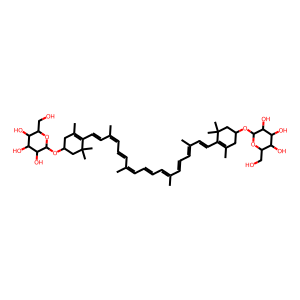

SMILES: CC(C=CC=C(C)C=CC1=C(C)CC(O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1=C(C)CC(OC2OC(CO)C(O)C(O)C2O)CC1(C)C
Name ['10963664']


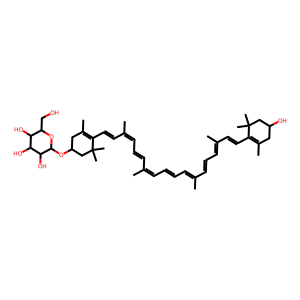

############################################### compound number: 1386##############################################################
Ground Truth NMR


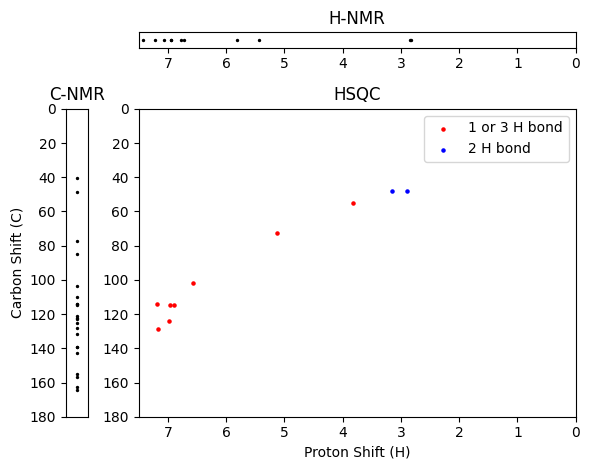

Chemical name Ohioensin F
Ground truth smiles O=C1CC2(O)c3ccccc3OC3c4cc(O)ccc4-c4c(O)cc(O)c1c4C32


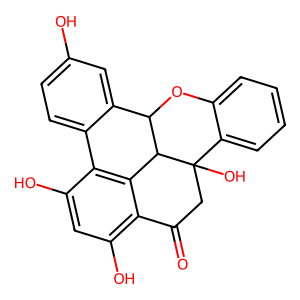

Prediction's cosine similarity to ground truth:  0.712211012840271
SMILES: COc1cc(O)c2c(c1)OC(c1ccc(O)cc1O)CC2=O
Name ['2-(2,4-dihydroxy-phenyl)-5-hydroxy-7-methoxy-chroman-4-one', 'Artocarpanon', 'Artocarpanone']


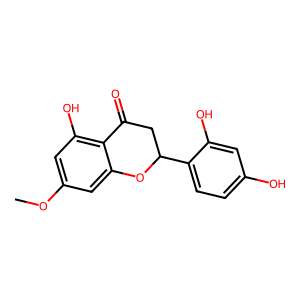

SMILES: COc1cc(O)c2c(c1)OC(c1cc(O)ccc1O)CC2=O
Name ["(2S)-5,2',5'-trihydroxy-7-methoxyflavanone"]


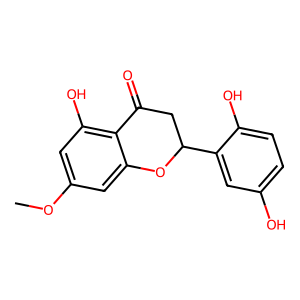

SMILES: COc1cc(C2CC(=O)c3ccc(O)cc3O2)ccc1O
Name ['15385487']


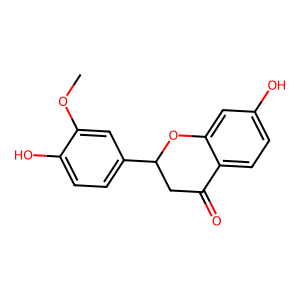

############################################### compound number: 2525##############################################################
Ground Truth NMR


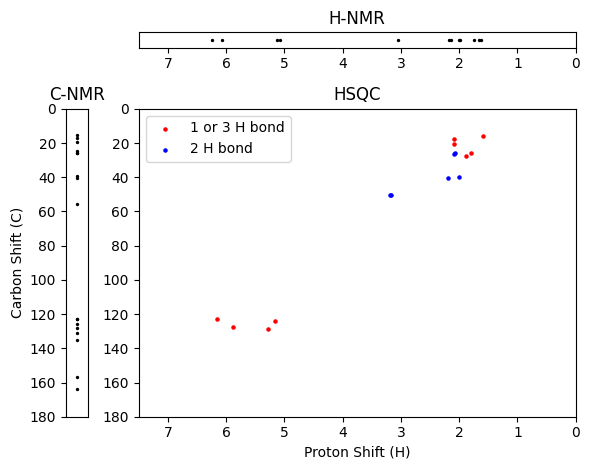

Chemical name 111950-82-4
Ground truth smiles CC(C)=CC(=O)CC(C)=CCCC(C)=CCCC(C)=CC=O


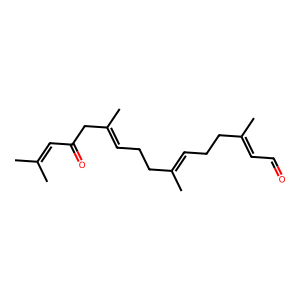

Prediction's cosine similarity to ground truth:  0.9153856635093689
SMILES: CC(C)=CC(=O)CC(C)=CCCC(C)=CCCC(C)=CC=O
Name ['iso-eleganonal', '111950-82-4', 'eleganonal']


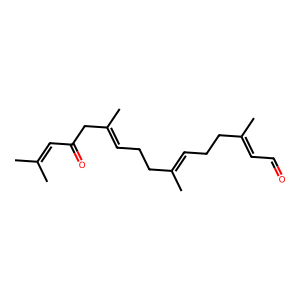

SMILES: CC(=O)CCC=C(C)CCC=C(C)CC(=O)C=C(C)C
Name ['(E,E)-6,10,14-Trimethyl-5,9,13-pentadecatriene-2,12-dione', '(5E,9E)-6,10,14-Trimethyl-5,9,13-pentadecatriene-2,12-dione', '(5E,9E)-6,10,14-trimethyl-pentadeca-5,9,13-triene-2,12-dione']


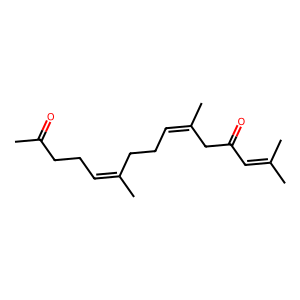

SMILES: CC=C(C)CCC=C(C)CCC=C(C)CC(=O)C=C(C)C
Name ['Isoeleganonal']


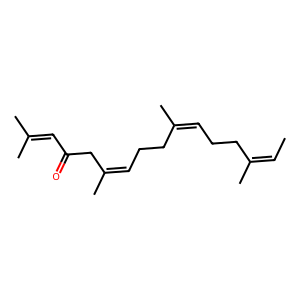

############################################### compound number: 2061##############################################################
Ground Truth NMR


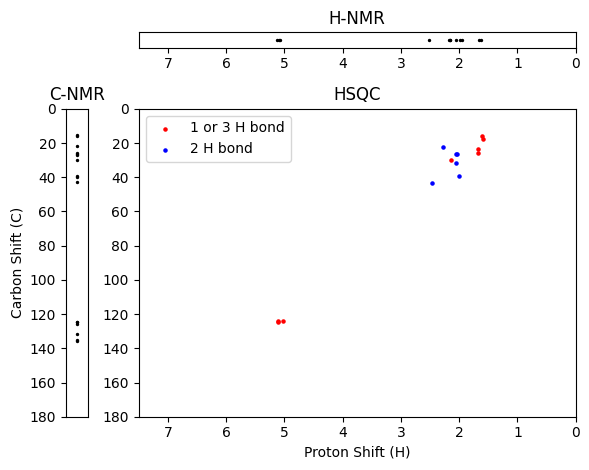

Chemical name (5E,9E)-6,10,14-Trimethyl-5,9,13-pentadecatrien-2-one
Ground truth smiles CC(=O)CCC=C(C)CCC=C(C)CCC=C(C)C


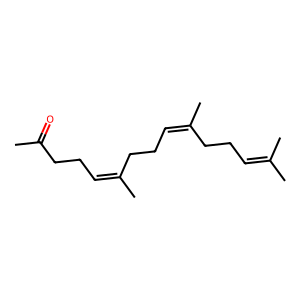

Prediction's cosine similarity to ground truth:  0.9791666865348816
SMILES: CC(=O)CCC=C(C)CCC=C(C)CCC=C(C)C
Name ['famesylacetone', '(5Z,9E)-6,10,14-trimethyl-pentadeca-5,9,13-trien-2-one', '6,10,14-trimethyl-pentadeca-5c,9t,13-trien-2-one', '6,10,14-Trimethyl-5,9,13-pentadecatrien-2-one', 'cis,trans-farnesylacetone', '(5Z,9E)-farnesyl acetone', '(5E,9E)-6,10,14-Trimethyl-5,9,13-pentadecatrien-2-one', '(6E,10Z)-2,6,10-trimethyl-2,6,10-pentadecatrien-14-one', '6,10,14-Trimethyl-pentadeca-5c,9t,13-trien-2-on']


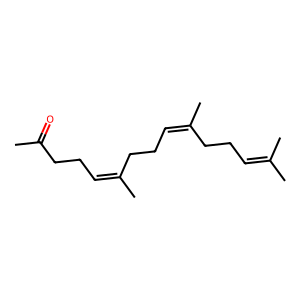

SMILES: CC(=O)CCC=C(C)CCC=C(C)C
Name ['6,10-Dimethylundeca-5,9-Dien-2-One']


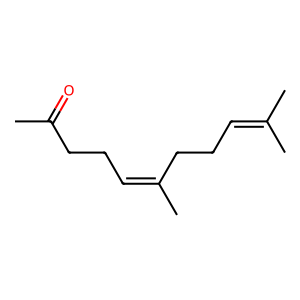

SMILES: CC(=O)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C
Name ['geranylfarnesylacetone', '86541-61-9']


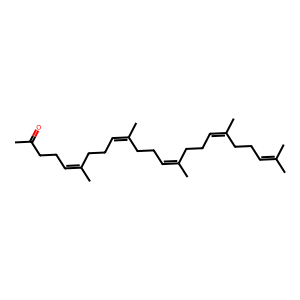

############################################### compound number: 4964##############################################################
Ground Truth NMR


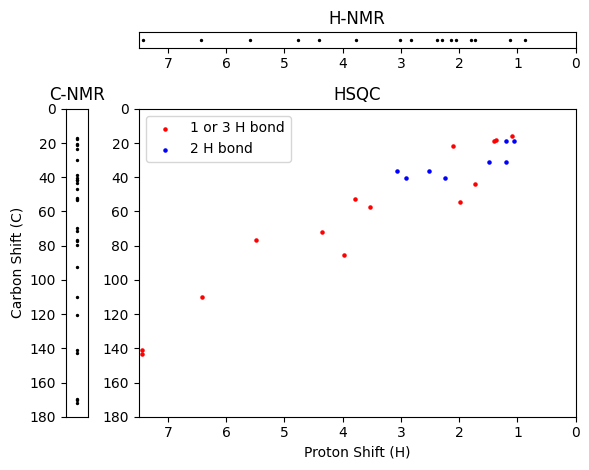

Chemical name 1-O-acetylkhayanolide A
Ground truth smiles COC(=O)C(O)C1C2(C)CC3(OC(C)=O)C(C(=O)C2O)C24OC25CC(=O)OC(c2ccoc2)C5(C)CCC4C13C


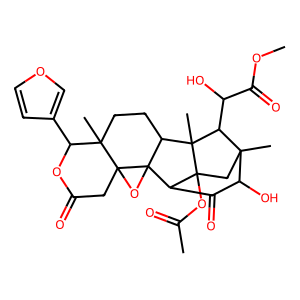

Prediction's cosine similarity to ground truth:  0.8062630295753479
SMILES: COC(=O)C(O)C1C2(C)CC3(OC(C)=O)C(C(=O)C2O)C24OC25CC(=O)OC(c2ccoc2)C5(C)CCC4C13C
Name ['1-O-acetylkhayanolide A']


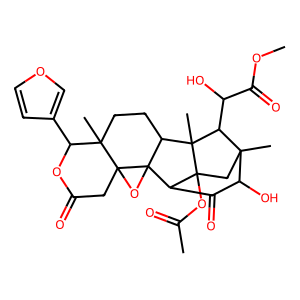

SMILES: COC(=O)C(O)C1C2(C)CC3(O)C(C(=O)C2O)C24OC25CC(=O)OC(c2ccoc2)C5(C)CCC4C13C
Name ['Khayanolide A', 'khayanolide A']


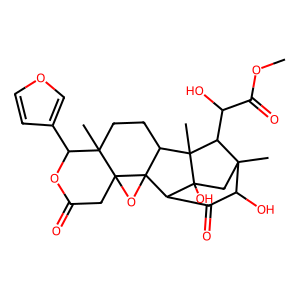

SMILES: COC(=O)C(O)C1C2(C)CC3(OC(C)=O)C4C(OC)(OC56CC(=O)OC(c7ccoc7)C5(C)CCC(C13C)C46O)C2O
Name ['Methyl (2R)-[(1S,2R,3R,4R,7S,8S,12R,14R,15S,16S,17S,18S)-1-acetoxy-8-(3-furyl)-3,15-dihydroxy-14-methoxy-7,16,18-trimethyl-10-oxo-9,13-dioxahexacyclo[14.2.1.0~2,14~.0~3,12~.0~4,18~.0~7,12~]nonadec-17-\r\nyl](hydroxy)acetate', '188847-85-0']


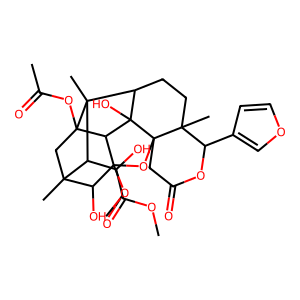

############################################### compound number: 1739##############################################################
Ground Truth NMR


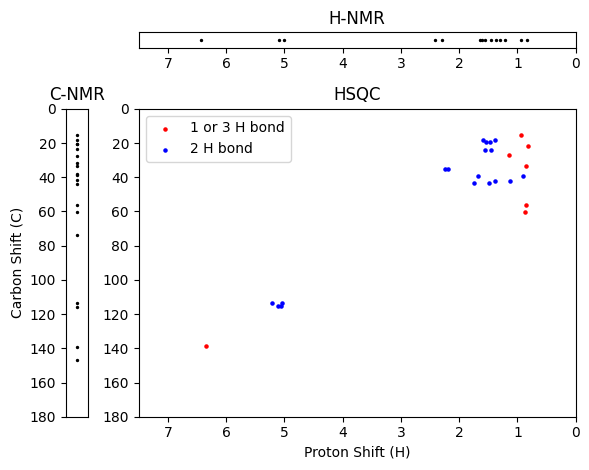

Chemical name 791853-86-6
Ground truth smiles C=CC(=C)CCC1C(C)(O)CCC2C(C)(C)CCCC21C


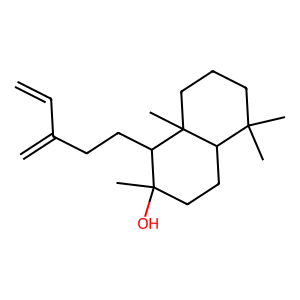

Prediction's cosine similarity to ground truth:  0.833333432674408
SMILES: C=CC(=C)CCC1C(C)(O)CCC2C(C)(C)CCCC21C
Name ['Isoabienol', '791853-86-6']


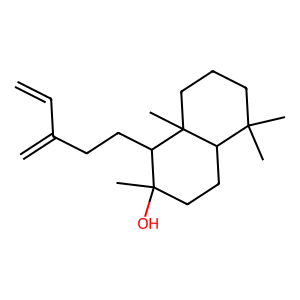

SMILES: C=C(C)CCC1C(C)(O)CCC2C(C)(C)CCCC21C
Name ['91747372']


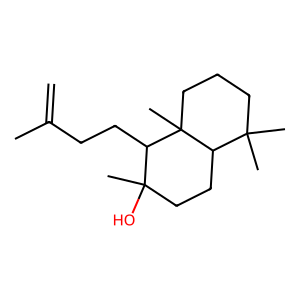

SMILES: C=CC(C)=CCC1C(C)(O)CCC2C(C)(C)CCCC21C
Name ['(8R)-trans-Labda-12,15-dien-8-ol', '(E)-12,14-labdadien-8-ol', '(2R,4aS,8aS)-2,5,5,8a-Tetramethyl-1-[(2Z)-3-methyl-2,4-pentadien-1-yl]decahydro-2-naphthalenol']


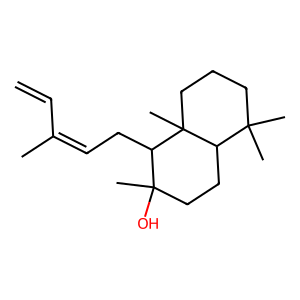

############################################### compound number: 4971##############################################################
Ground Truth NMR


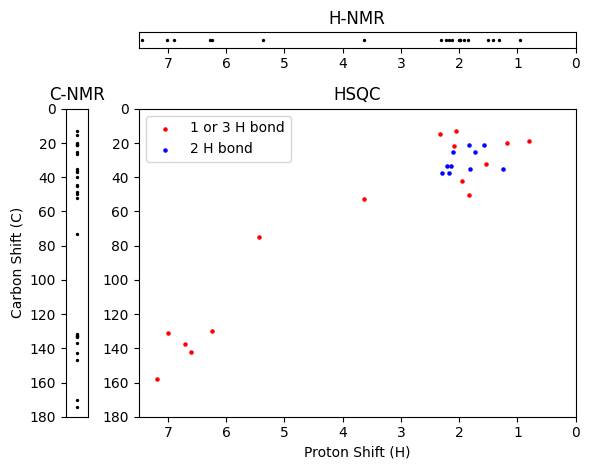

Chemical name 3-O-Acetyl-Jaspiferal B Methyl Ester
Ground truth smiles COC(=O)C1(C)C(OC(C)=O)CCC2(C)C3CC(=O)C(=C(C)C=CC=C(C)C=CC=O)C3(C)CCC21


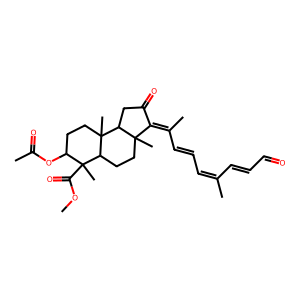

Prediction's cosine similarity to ground truth:  0.8692060112953186
SMILES: COC(=O)C1(C)C(OC(C)=O)CCC2(C)C3CC(=O)C(=C(C)C=CC=C(C)C=CC=O)C3(C)CCC21
Name ['3-O-acetyljaspiferal B methyl ester', '3-O-Acetyl-Jaspiferal B Methyl Ester']


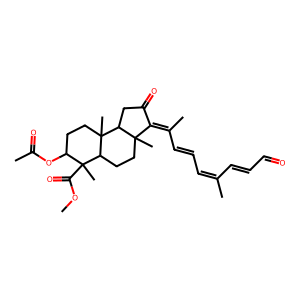

SMILES: COC(=O)C1(C)C(OC(C)=O)CCC2(C)C3CC(=O)C(=C(C)C=CC=C(C)C=O)C3(C)CCC21
Name ['3-O-acetyljaspiferal D methyl ester', '3-O-Acetyl-Jaspiferal D Methyl Ester']


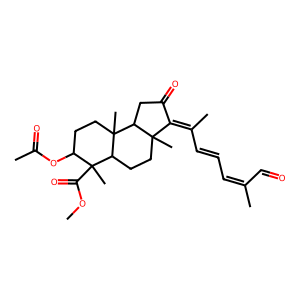

SMILES: COC(=O)C1(C)C(OC(C)=O)CCC2(C)C3CC(=O)C(=C(C)C=CC=C(C)C=CC=C(C)C)C3(C)CCC21
Name ['13E,17E-globostellatic acid X methyl est', 'methyl (13Z,15E,17E,22E)-3beta-acetoxy-12-oxomalabarica-13,15,17,22,24-pentaen-28-oate', '13E,17Z-globostellatic acid X methyl est', '13Z,17E-globostellatic acid X methyl est', '13Z,17Z-globostellatic acid X methyl est']


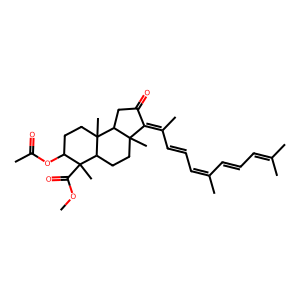

############################################### compound number: 293##############################################################
Ground Truth NMR


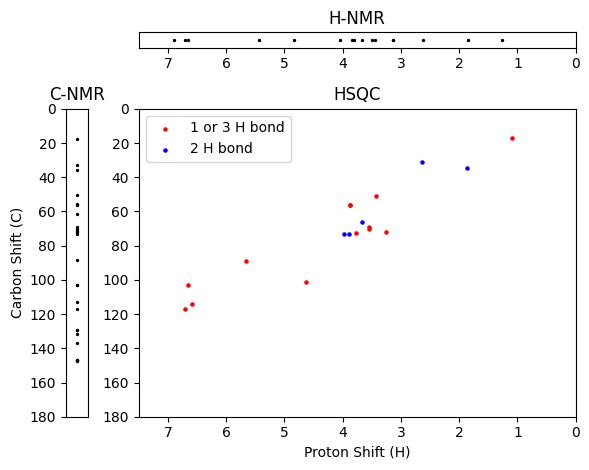

Chemical name [(2R,3S)-2-(4-Hydroxy-3,5-dimethoxyphenyl)-5-(3-hydroxypropyl)-7-methoxy-2,3-dihydro-1-benzofuran-3-yl]methyl 6-deoxy-alpha-L-mannopyranoside
Ground truth smiles COc1cc(C2Oc3c(OC)cc(CCCO)cc3C2COC2OC(C)C(O)C(O)C2O)cc(OC)c1O


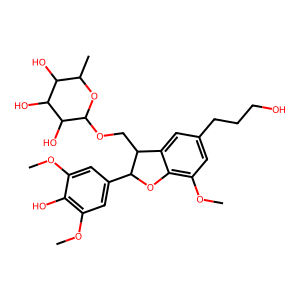

Prediction's cosine similarity to ground truth:  0.9183336496353149
SMILES: COc1cc(C2Oc3c(OC)cc(CCCO)cc3C2COC2OC(C)C(O)C(O)C2O)cc(OC)c1O
Name ['[(2R,3S)-2-(4-Hydroxy-3,5-dimethoxyphenyl)-5-(3-hydroxypropyl)-7-methoxy-2,3-dihydro-1-benzofuran-3-yl]methyl 6-deoxy-alpha-L-mannopyranoside', '[(2S,3R)-2-(4-Hydroxy-3,5-dimethoxyphenyl)-5-(3-hydroxypropyl)-7-methoxy-2,3-dihydro-1-benzofuran-3-yl]methyl 6-deoxy-alpha-L-mannopyranoside']


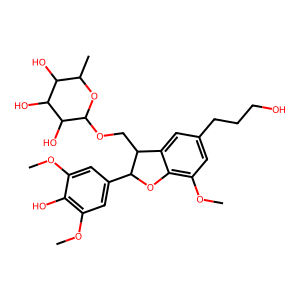

SMILES: COc1cc(C2Oc3c(OC)cc(CCCO)cc3C2COC2OC(C)C(O)C(O)C2O)ccc1O
Name ['3\',7-Di-Me ether,1"-O-alpha-L-rhamnopyranoside-(2R,3S)-2-(3,4-Dihydroxyphenyl)-2,3-dihydro-7-hydroxy-3-hydroxymethyl-5-benzofuranpropanol', '[(2S,3R)-2-(4-Hydroxy-3-methoxyphenyl)-5-(3-hydroxypropyl)-7-methoxy-2,3-dihydro-1-benzofuran-3-yl]methyl 6-deoxy-alpha-L-mannopyranoside']


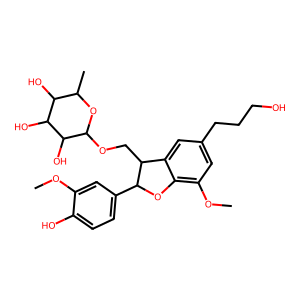

SMILES: COc1ccc(C2Oc3c(OC)cc(CCCO)cc3C2COC2OC(C)C(O)C(O)C2O)cc1O
Name ["2,3-dihydrobenzofuran-2-(4'-hydroxy-3'-methoxyphenyl)-3-alpha-L-rhamnopyranosyloxymethyl-7-methoxy-5-propanol"]


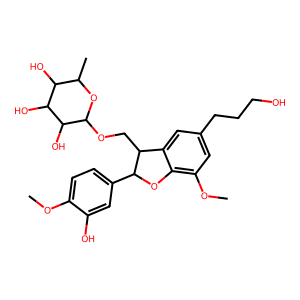

############################################### compound number: 4762##############################################################
Ground Truth NMR


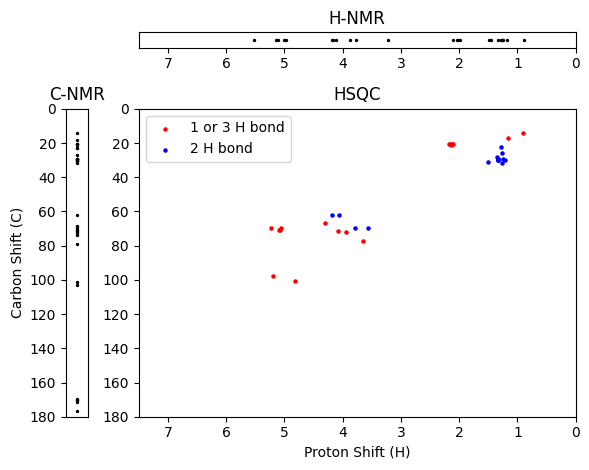

Chemical name 862587-16-4
Ground truth smiles CCCCCCCCCCCCCCCCOC1OC(COC(C)=O)C(OC(C)=O)C(O)C1OC1OC(C)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O


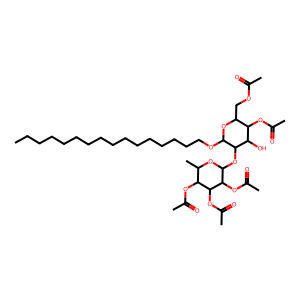

Prediction's cosine similarity to ground truth:  0.903509259223938
SMILES: CCCCCCCCCCCCCCCCOC1OC(COC(C)=O)C(O)C(O)C1OC1OC(C)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O
Name ['hexadecyl-[O-2,3,4-tri-O-acetyl-alpha-L-rhamnopyranosyl-(1->2)]-6-O-acetyl-beta-D-glucopyranoside', 'matayoside D']


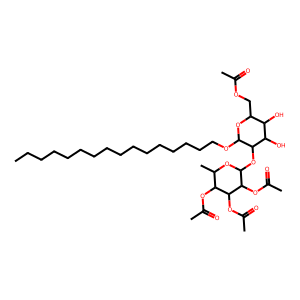

SMILES: CCCCCCCCCCCCCCCCOC1OC(COC(C)=O)C(OC(C)=O)C(O)C1OC1OC(C)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O
Name ['862587-16-4']


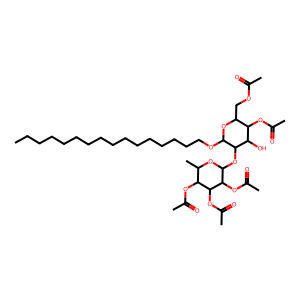

SMILES: CCCCCCCCCCCCCCCCOC1OC(COC(C)=O)C(O)C(OC(C)=O)C1OC1OC(C)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O
Name ['hexadecyl-[O-2,3,4-tri-O-acetyl-alpha-L-rhamnopyranosyl-(1->2)]-3,6-di-O-acetyl-beta-D-glucopyranoside', 'matayoside C']


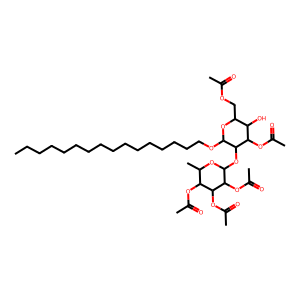

############################################### compound number: 1298##############################################################
Ground Truth NMR


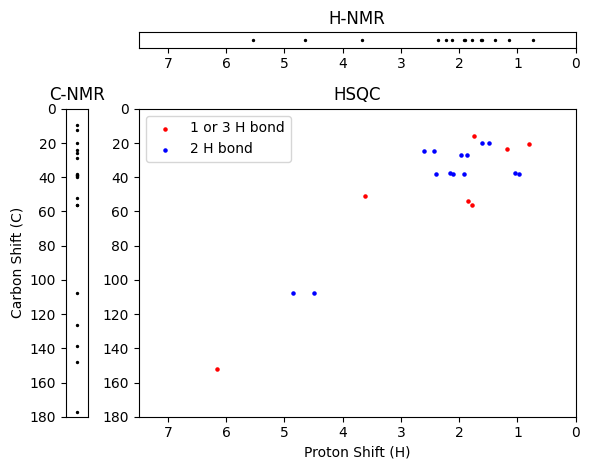

Chemical name 14431992
Ground truth smiles C=C1CCC2C(C)(C(=O)OC)CCCC2(C)C1CC=C(C)C=O


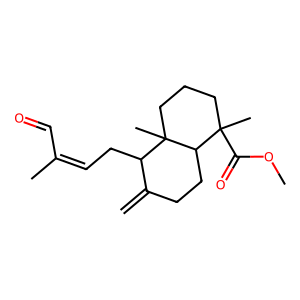

Prediction's cosine similarity to ground truth:  0.9023354649543762
SMILES: C=C1CCC2C(C)(C(=O)OC)CCCC2(C)C1CC=C(C)C=O
Name ['14431992']


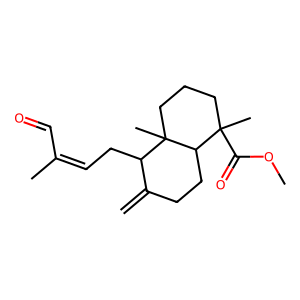

SMILES: C=C1CCC2C(C)(C(=O)O)CCCC2(C)C1CC=C(C)C=O
Name ['15-Nor-14-Oxolabda-8(17),12E-Dien-19-Oic Acid', '1039673-32-9']


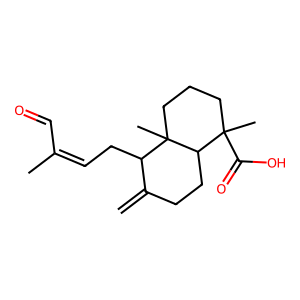

SMILES: C=C1CCC2C(C)(C)CCCC2(C)C1CC=C(C=O)CC(=O)OC
Name ['Pahangensin B', 'pahangensin B']


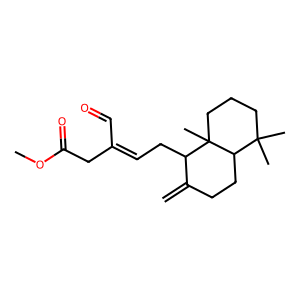

############################################### compound number: 3529##############################################################
Ground Truth NMR


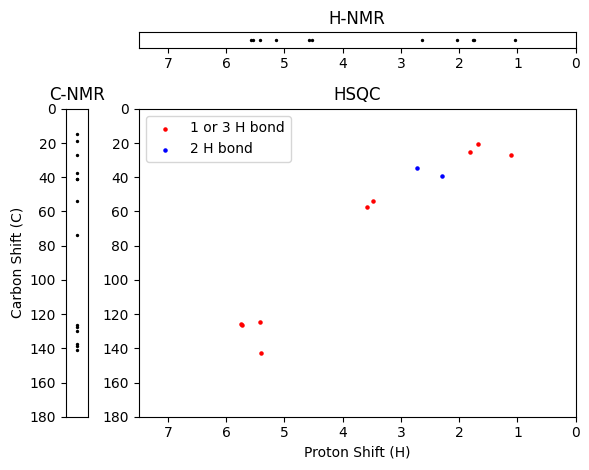

Chemical name 91750424
Ground truth smiles CC1=CC2OC2C(C)=CCC(C)(C)C=CC1


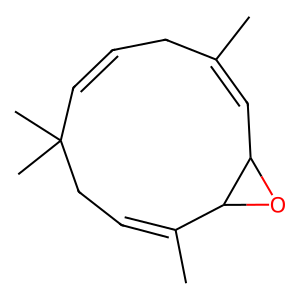

Prediction's cosine similarity to ground truth:  0.8317884206771851
SMILES: CC1=CC2OC2C(C)=CCC(C)(C)C=CC1
Name ['91750424']


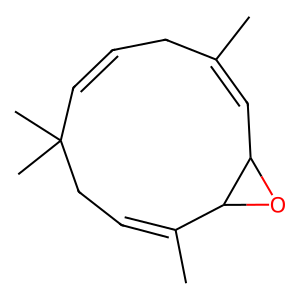

SMILES: CC1=CCCC(C)=CCC2(C)OC2CC(C)(C)C=CC1
Name ['epoxyflexibilene']


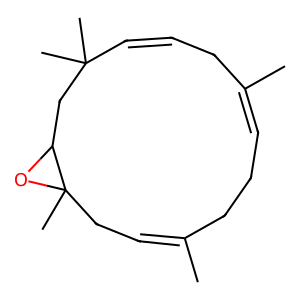

SMILES: CC1=CCC(C)(C)C=CCC2(C)OC2CC1
Name ['23274265']


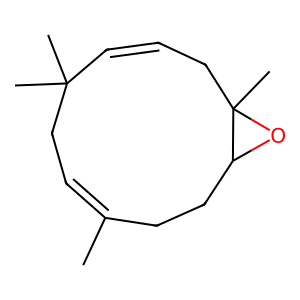

############################################### compound number: 5231##############################################################
Ground Truth NMR


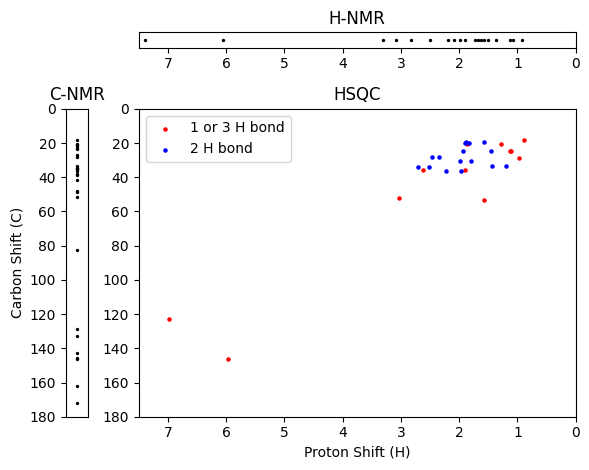

Chemical name (2Z,6R)-6-[(4aR,6aR,6bR,9R,11bS)-10-Formyl-6a-methoxy-4,4,6b,11b-tetramethyl-3-oxo-2,3,4,4a,5,6,6a,6b,7,8,9,11b-dodecahydro-1H-benzo[a]fluoren-9-yl]-2-methyl-2-heptenoic acid
Ground truth smiles COC12CCC3C(C)(C)C(=O)CCC3(C)C1=CC1=C(C=O)C(C(C)CCC=C(C)C(=O)O)CCC12C


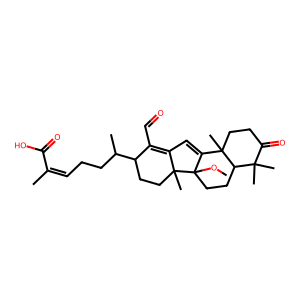

Prediction's cosine similarity to ground truth:  0.8204125761985779
SMILES: COC12CCC3C(C)(C)C(=O)CCC3(C)C1=CC1=C(C=O)C(C(C)CCC=C(C)C(=O)O)CCC12C
Name ['(2Z,6R)-6-[(4aR,6aR,6bR,9R,11bS)-10-Formyl-6a-methoxy-4,4,6b,11b-tetramethyl-3-oxo-2,3,4,4a,5,6,6a,6b,7,8,9,11b-dodecahydro-1H-benzo[a]fluoren-9-yl]-2-methyl-2-heptenoic acid']


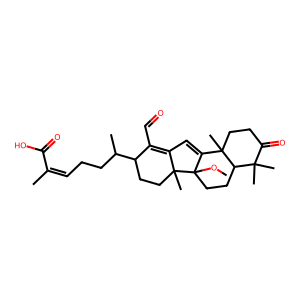

SMILES: CC(=CCCC(C)C1CCC2(C)C3CCC4C(C)(C)C(=O)CCC4(C)C3=CCC12C)C(=O)O
Name ['Coccinic acid']


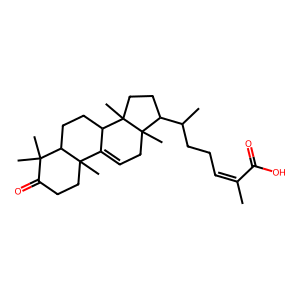

SMILES: CC(=O)OC1C=C2C(CCC3C(C)(C)C(=O)CCC23C)C2(C)CCC(C(C)CCC=C(C)C(=O)O)C12C
Name ['No_name']


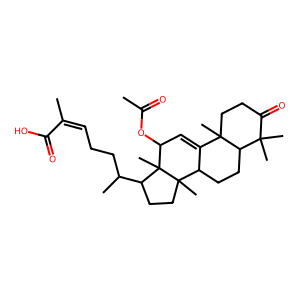

############################################### compound number: 3224##############################################################
Ground Truth NMR


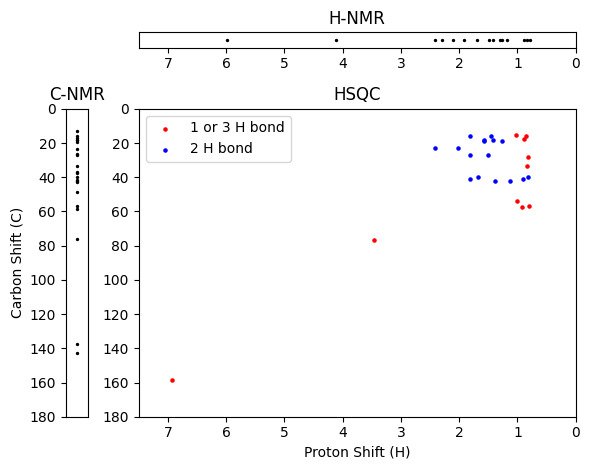

Chemical name 12-deacetyl-Δ17-hyrtial
Ground truth smiles CC1(C)CCCC2(C)C1CCC1(C)C3CCC(C=O)=CC3(C)C(O)CC21


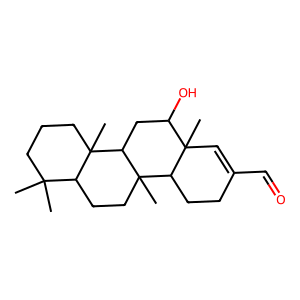

Prediction's cosine similarity to ground truth:  0.8269317150115967
SMILES: CC1(C)CCCC2(C)C1CCC1(C)C3CCC(C=O)=CC3(C)C(O)CC21
Name ['12-deacetyl-Δ17-hyrtial']


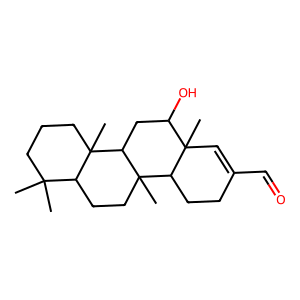

SMILES: CC1(C)CCCC2(C)C1CCC1(C)C3CC(O)C(C=O)=CC3(C)C(O)CC21
Name ['12-O-deacetylnorscalaral B']


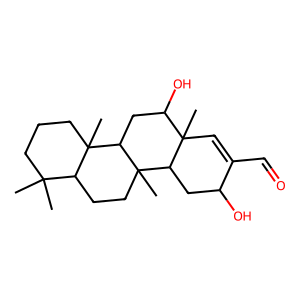

SMILES: CC1(C)CCCC2(C)C1CCC1(C)C3CC=C(C=O)CC3(C)C(O)CC21
Name ['De-O-acetylhyrtial', '(4aS,4bR,6aS,10aS,10bR,12R,12aR)-12-Hydroxy-4b,7,7,10a,12a-pentamethyl-1,4,4a,4b,5,6,6a,7,8,9,10,10a,10b,11,12,12a-hexadecahydro-2-chrysenecarbaldehyde']


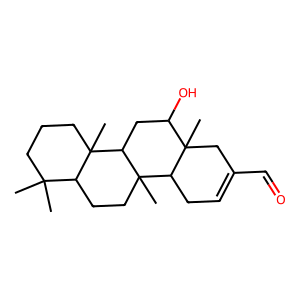

############################################### compound number: 4171##############################################################
Ground Truth NMR


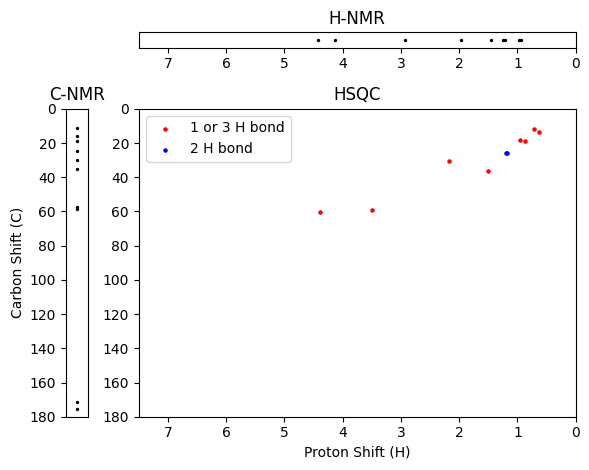

Chemical name 449407
Ground truth smiles CCC(C)C(N)C(=O)NC(C(=O)O)C(C)C


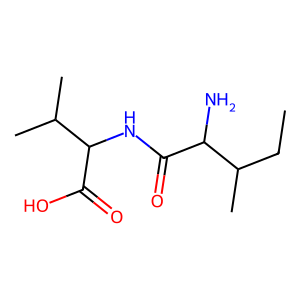

Prediction's cosine similarity to ground truth:  0.8531677722930908
SMILES: CCC(C)C(NC(=O)C(N)C(C)C)C(=O)O
Name ['7010532']


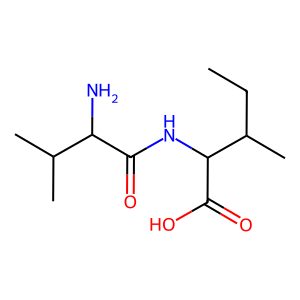

SMILES: CCC(C)C(N)C(=O)NC(C(=O)O)C(C)C
Name ['449407']


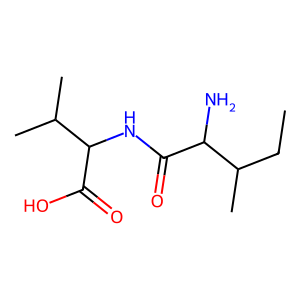

SMILES: CCC(C)C(NC(=O)C(C)N)C(=O)O
Name ['Ala-Ile', '7408079']


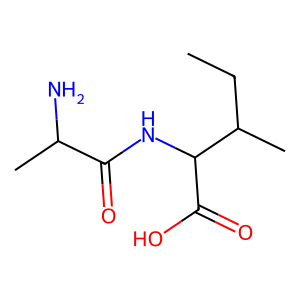

############################################### compound number: 3048##############################################################
Ground Truth NMR


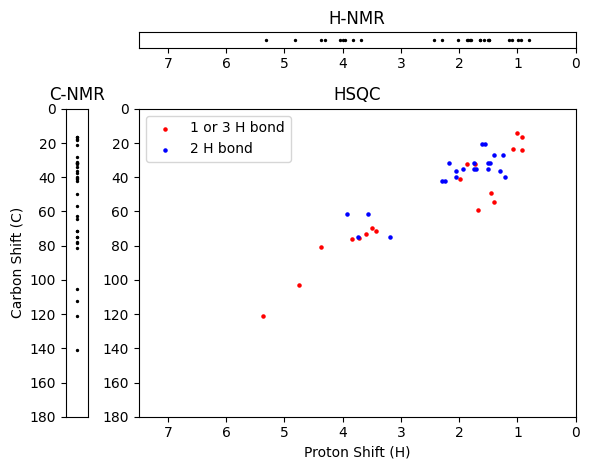

Chemical name 172586-06-0
Ground truth smiles CC(CCC1(O)OC2CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)C2C1C)COC1OC(CO)C(O)C(O)C1O


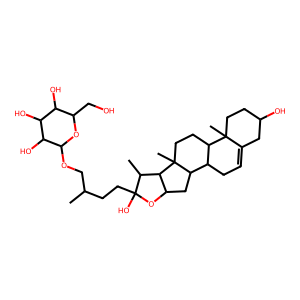

Prediction's cosine similarity to ground truth:  0.9311525821685791
SMILES: CC(CCC1(O)OC2CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)C2C1C)COC1OC(CO)C(O)C(O)C1O
Name ['172586-06-0']


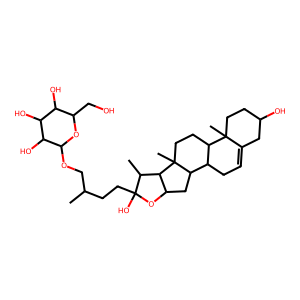

SMILES: CC(CCC1(O)OC2CC3C4CC=C5CC(OC6OC(CO)C(O)C(O)C6O)CCC5(C)C4CCC3(C)C2C1C)COC1OC(CO)C(O)C(O)C1O
Name ['lilioglycoside K']


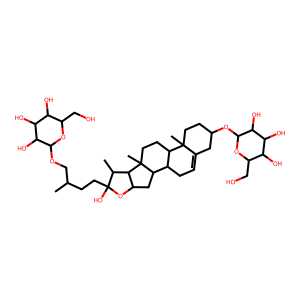

SMILES: CC(CCC1(O)OC2CC3C4CC=C5CC(O)CC(O)C5(C)C4CCC3(C)C2C1C)COC1OC(CO)C(O)C(O)C1O
Name ['nolinofuroside A']


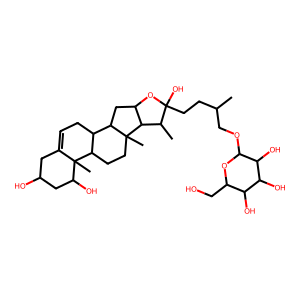

############################################### compound number: 4458##############################################################
Ground Truth NMR


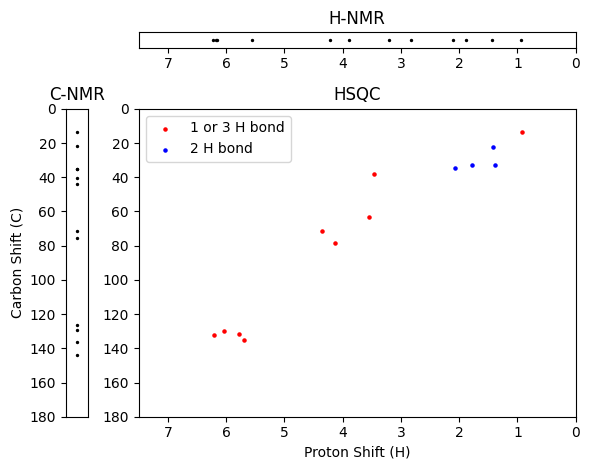

Chemical name Frequentin
Ground truth smiles CCCC=CC=CC1CC(O)C(O)C(=O)C1C=O


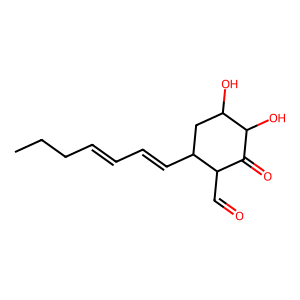

Prediction's cosine similarity to ground truth:  0.8183436989784241
SMILES: CCCC=CC=CC1CC(O)C(O)C(=O)C1C=O
Name ['Frequentin']


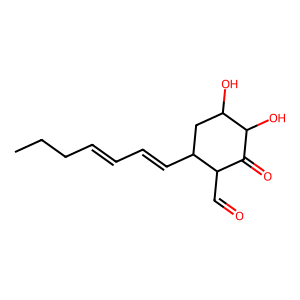

SMILES: CCCC=CC=CC1CC(O)C(O)C(=O)C1CO
Name ['15265-28-8', '(2R,3S,5R,6R)-3-((1E,3E)-Hepta-1,3-Dienyl)-5,6-Dihydroxy-2-Hydroxymethyl-Cyclohexanone']


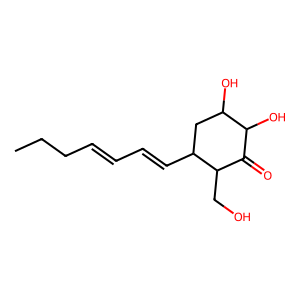

SMILES: CCCC=CC=CC1CC(O)CC(=O)C1CO
Name ['186900-40-3', 'Penihydrone']


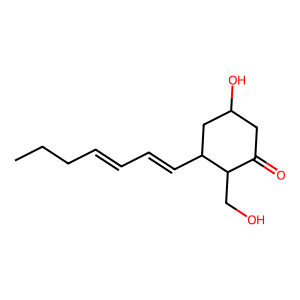

############################################### compound number: 3645##############################################################
Ground Truth NMR


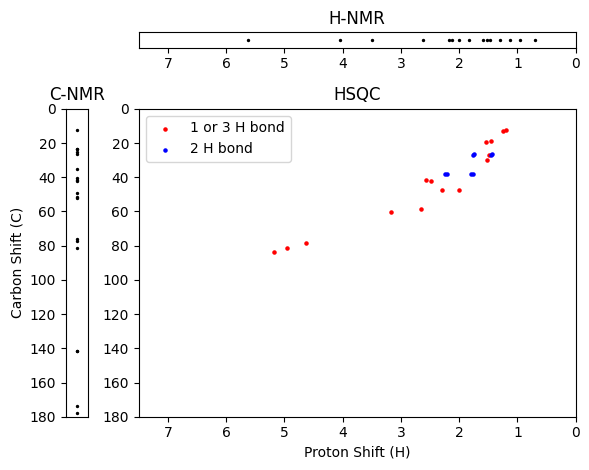

Chemical name Absintholide
Ground truth smiles CC1C(=O)OC2C3=C(C4C(=O)C3(C)C3C(O)C5=C(C6OC(=O)C(C)C6CCC5(C)O)C43C)C(C)(O)CCC12


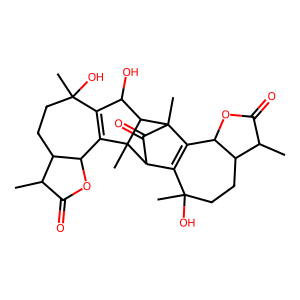

Prediction's cosine similarity to ground truth:  0.7226021885871887
SMILES: CC1C(=O)OC2C3=C(C4C(=O)C3(C)C3C(O)C5=C(C6OC(=O)C(C)C6CCC5(C)O)C43C)C(C)(O)CCC12
Name ['Absintholide']


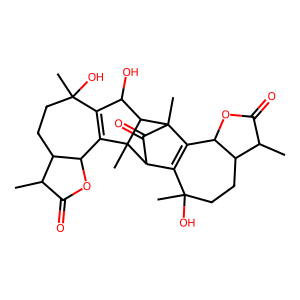

SMILES: CC1C(=O)OC2C3=C(C(O)C(O)C3(C)O)C(C)(O)CCC12
Name ['No_name']


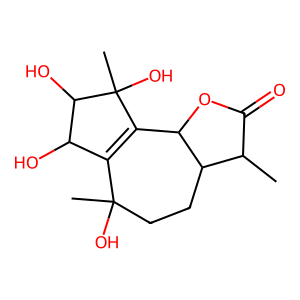

SMILES: CC1C(=O)OC2C3=C(C(O)CC3(C)O)C(C)(O)CCC12
Name ['No_name']


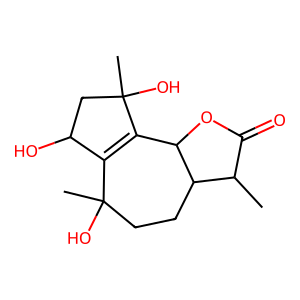

DONE






In [16]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# model.to("cuda")
for  which_compound in  random.sample(range(len(loader_all_inputs.dataset)), k=20):# range(0, 1):  
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(loader_all_inputs):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
        inputs = inputs.to("cuda")
        pred = model(inputs)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    plot_NMR(hsqc, c_tensor, h_tensor)
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=3)
    # ground truth
    smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
    
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        # print(f"________retival #{i+1}, cosine similarity: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [17]:
# '''
# Show only incorrect inference examples
# '''

# # model.to("cuda")
# i=0
# for idx, batch in enumerate(loader_all_inputs):
    
#     inputs, (smiles_chemical_name) = batch
#     hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
#     inputs = inputs.to("cuda")
#     pred = model(inputs)
#     pred=torch.sigmoid(pred) # sigmoid
#     pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
#     # print(pred_FP.nonzero().squeeze().tolist())

    
#     topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
#     # ground truth
#     smiles, names, path = zip(*smiles_chemical_name)
    
#     ground_truth_smiles = smiles[0]
    
    
#     for value, (smile, name, _, _), retrieved_FP in topk:
#         if smile != ground_truth_smiles:
#             i+=1
#             print(f"____________________incorrect retival #{i+1}________________________")
#             print("Ground Truth NMR")
#             plot_NMR(hsqc, c_tensor, h_tensor)
#             ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(ground_truth_smiles)
#             print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
            
            
            
#             mol = Chem.MolFromSmiles(smiles[0])
#             print(f"Chemical name {names[0]}")
#             print(f"Ground truth smiles {smiles[0]}")
#             # print(f"Ground truth NMR path {path[0]}")
#             img = Draw.MolToImage(mol)
#             img.show()

           
#             mol = Chem.MolFromSmiles(smile)
           
#             print(f"SMILES: {smile}")
#             print(f"Name {name}")
#             img = Draw.MolToImage(mol)
#             img.show()
    
#     if i==80:
#         break    
        
        
        


    



In [18]:
idx

1385

In [19]:
def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

 

In [28]:


"""
Nice !
Now we can play with unkown molecule
"""
hsqc_mode = None
'''for a single model, show top-5'''
def show_topK(inputs, k=5, mode = hsqc_mode, ground_truth_FP=None):
    print("_________________________________________________________")

    
    inputs = inputs.unsqueeze(0).to("cuda")
    pred = model(inputs)
    pred = torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    if ground_truth_FP is not None:
        print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()))
        print("\n\n")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k)
       
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, retrival cosine similarity to prediction: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        if ground_truth_FP is not None:
            retrieved_FP_6144 = torch.zeros(6144)
            retrieved_FP_6144[retrieved_FP.cpu()] = 1
            print("Retrival's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, retrieved_FP_6144))
        print(f"SMILES: {smile}")
        print(f"Name {name}")
       
        #check is path file exists
        # print("retrieved path: ",oned_path)

        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [21]:
def build_input(compound_dir, mode = hsqc_mode, include_hsqc = True, include_c_nmr = True, include_h_nmr = True):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    input_NMRs = []
    if include_hsqc:
        input_NMRs+= [get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end")]
    if include_c_nmr:
        input_NMRs+= [get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end")]
    if include_h_nmr:
        input_NMRs+= [get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end")]
    inputs = torch.vstack(input_NMRs)   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    # plot_NMR(hsqc, c_tensor[:,0], h_tensor[:,0])
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])

In [22]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

In [23]:
(newCompoundA_FP.dtype)

torch.float32

In [29]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1


____________________________retival #1, cosine similarity: 0.6377196311950684_____________________________
retrived FP [6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 77, 83, 109, 112, 113, 114, 117, 120, 124, 126, 128, 131, 134, 135, 136, 137, 138, 141, 144, 166, 167, 168, 169, 171, 172, 176, 177, 186, 193, 195, 201, 214, 216, 218, 219, 222, 224, 225, 238, 240, 241, 242, 258, 261, 266, 272, 284, 285, 349, 350, 352, 491, 502, 503, 504, 531, 573, 574, 575, 577, 578, 580, 597, 601, 612, 635, 636, 637, 662, 679, 680, 691, 782, 822, 833, 837, 900, 945, 1000, 1045, 1083, 1101, 1184, 1205, 1269, 1312, 1408, 1478, 1524, 1661, 1973, 2013, 2096, 2190, 2229, 2303, 2330, 2381, 2457, 2548, 2875, 2925, 3015, 3211, 3392, 3728, 3739, 3746, 3875, 4014, 4073, 4089, 4123, 4297, 4512, 4626, 4783, 4837, 4929, 5240, 5339, 5665, 5792, 5919]
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name ['934248-75-6',

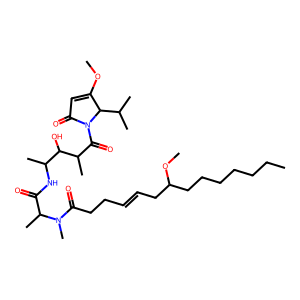

____________________________retival #2, cosine similarity: 0.6094380617141724_____________________________
retrived FP [0, 5, 6, 8, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 77, 83, 99, 100, 101, 102, 103, 112, 113, 114, 127, 129, 135, 136, 137, 138, 140, 141, 143, 167, 168, 169, 171, 172, 195, 214, 222, 224, 225, 239, 240, 241, 242, 256, 258, 261, 264, 334, 342, 349, 350, 352, 361, 375, 385, 502, 503, 504, 531, 544, 557, 573, 574, 575, 577, 578, 580, 597, 612, 635, 636, 637, 662, 672, 679, 680, 691, 712, 725, 745, 776, 778, 782, 788, 822, 827, 926, 1015, 1141, 1204, 1227, 1312, 1378, 1381, 1408, 1455, 1633, 1661, 1669, 1883, 1894, 1995, 2013, 2048, 2085, 2190, 2303, 2381, 2445, 2599, 2700, 2754, 2925, 3007, 3175, 3235, 3266, 3481, 3599, 3983, 4089, 4123, 4249, 4297, 4352, 4512, 4797, 4997, 5339, 5468, 5665, 5816, 6009]
SMILES: CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)NC(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
Name ['102147668']


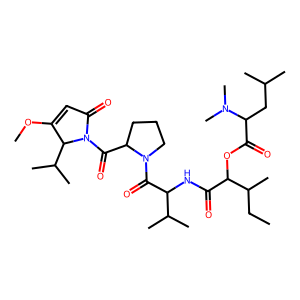

____________________________retival #3, cosine similarity: 0.6037452816963196_____________________________
retrived FP [3, 4, 6, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 54, 55, 62, 64, 66, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 109, 112, 113, 114, 117, 134, 135, 136, 137, 138, 141, 144, 166, 167, 168, 169, 171, 172, 176, 177, 188, 191, 195, 198, 201, 214, 222, 224, 225, 240, 241, 242, 349, 350, 352, 521, 573, 574, 575, 577, 578, 580, 597, 612, 633, 635, 636, 637, 689, 691, 715, 725, 745, 764, 768, 778, 818, 843, 883, 952, 953, 1016, 1041, 1132, 1204, 1227, 1408, 1455, 1540, 1577, 1639, 1816, 1883, 2013, 2303, 3058, 3213, 3682, 4897, 4997, 5339]
SMILES: CCCCC(C)C(=O)NC(C(=O)N1C(=O)C(C)=C(OC)C1Cc1ccccc1)C(C)C
Name ["palau'imide"]


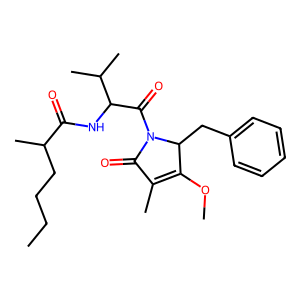

____________________________retival #4, cosine similarity: 0.5928528904914856_____________________________
retrived FP [3, 4, 6, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 112, 113, 114, 127, 135, 136, 137, 138, 141, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 222, 224, 225, 233, 234, 240, 241, 242, 258, 261, 349, 350, 352, 361, 375, 385, 502, 521, 573, 574, 575, 577, 578, 580, 597, 598, 607, 612, 635, 636, 637, 662, 679, 680, 691, 725, 745, 776, 778, 782, 822, 843, 952, 1015, 1016, 1132, 1141, 1204, 1227, 1312, 1376, 1408, 1440, 1455, 1478, 1669, 1721, 1883, 1996, 2013, 2048, 2096, 2303, 2534, 2663, 2754, 2837, 2925, 3257, 3266, 3392, 3636, 3913, 3924, 4089, 4297, 4512, 5000, 5330, 5339, 5665]
SMILES: CCC(C)C(C(=O)N1C(=O)C=C(OC)C1Cc1ccccc1)N(C)C(=O)C(C(C)C)N(C)C(=O)C(NC(=O)C(C(C)C)N(C)C)C(C)C
Name ['caldoramide']


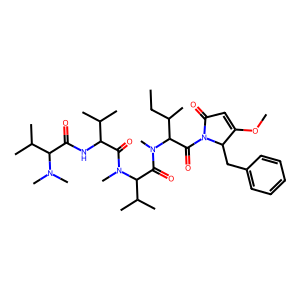

____________________________retival #5, cosine similarity: 0.5903822183609009_____________________________
retrived FP [6, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 112, 113, 114, 135, 136, 137, 138, 141, 167, 168, 169, 171, 172, 195, 204, 206, 207, 214, 222, 224, 225, 240, 241, 242, 258, 261, 349, 350, 352, 455, 465, 472, 551, 573, 574, 575, 577, 578, 580, 586, 597, 603, 635, 636, 637, 662, 712, 788, 839, 897, 912, 960, 1204, 1312, 1408, 1455, 1820, 1901, 1931, 2013, 2104, 2122, 2303, 2459, 2803, 2925, 3161, 3195, 3763, 3809, 4025, 4089, 4297, 4310, 4399, 4512, 4514, 4925, 5339, 5665, 6030]
SMILES: COC1=CC(=O)N(C(=O)C(CC(C)C(Cl)(Cl)Cl)NC(=O)CC(C)C(Cl)(Cl)Cl)C1C
Name ['(2S,5S,7S,15S)-Dysideapyrrolidone', 'dysideapyrrolidone', 'Dysideapyrrolidone']


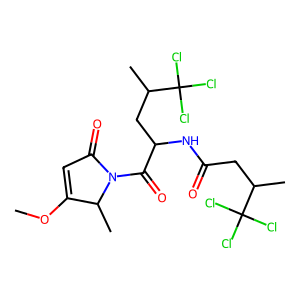

In [30]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=5)

In [31]:
deepSAT_sintokamide_B_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES("CCC(=O)N[C@H](C[C@H](C)C(Cl)(Cl)Cl)C(=O)N1[C@H](C(=CC1=O)OC)C[C@H](C)C(Cl)(Cl)Cl")
compute_cos_sim(deepSAT_sintokamide_B_FP, Kavaratamide_A_FP)

tensor(0.6227116585)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6870455742)



____________________________retival #1, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-docosancarbonsaeure-(2)-methylester; Mycolipanolsaeuremethylester']


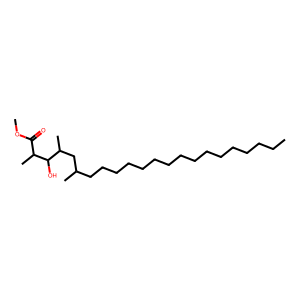

____________________________retival #2, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-heneicosancarbonsaeure-(2)-methylester; Mycolipanolsaeuremethylester']


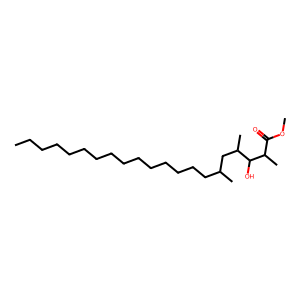

____________________________retival #3, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-tetracosancarbonsaeure-(2)-methylester']


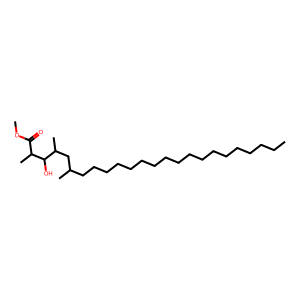

____________________________retival #4, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-pentacosancarbonsaeure-(2)-methylester']


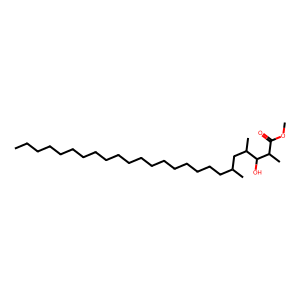

____________________________retival #5, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-hexacosancarbonsaeure-(2)-methylester']


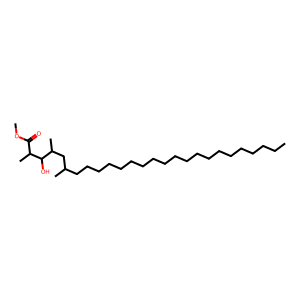

In [32]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5, mode=mode, ground_truth_FP = Kavaratamide_A_FP)
# show_topK(inputs, k=1)

____________________________retival #1, cosine similarity: 0.7450761795043945_____________________________
retrived FP [0, 1, 2, 3, 4, 5, 6, 9, 14, 16, 17, 22, 23, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 57, 59, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 99, 100, 101, 102, 103, 112, 113, 114, 134, 135, 136, 137, 138, 141, 144, 147, 150, 151, 153, 154, 155, 156, 157, 158, 166, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 216, 219, 222, 224, 225, 235, 240, 241, 242, 251, 259, 268, 297, 309, 319, 322, 323, 336, 337, 340, 341, 349, 350, 352, 354, 361, 362, 363, 367, 375, 377, 385, 386, 485, 496, 521, 573, 574, 575, 577, 578, 580, 592, 597, 598, 603, 612, 614, 617, 635, 636, 637, 674, 691, 755, 779, 798, 807, 816, 829, 833, 843, 848, 875, 887, 897, 918, 919, 920, 942, 948, 952, 973, 996, 1000, 1016, 1038, 1045, 1050, 1098, 1132, 1143, 1157, 1172, 1305, 1311, 1341, 1362, 1403, 1429, 1439, 1513, 1522, 1527, 1559, 1619, 1650, 1661, 1693, 1703, 1736, 1904, 1922, 1957, 

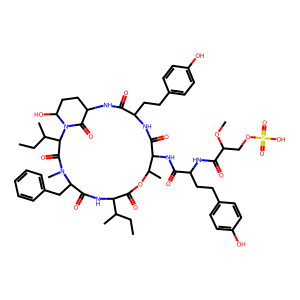

____________________________retival #2, cosine similarity: 0.7397352457046509_____________________________
retrived FP [0, 1, 2, 3, 4, 5, 6, 9, 14, 16, 17, 22, 23, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 57, 59, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 99, 100, 101, 102, 103, 112, 113, 114, 135, 136, 137, 138, 141, 147, 150, 151, 153, 154, 155, 156, 157, 158, 166, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 216, 219, 222, 224, 225, 235, 240, 241, 242, 251, 259, 268, 297, 309, 319, 322, 323, 336, 337, 340, 341, 349, 350, 352, 354, 361, 362, 363, 367, 375, 377, 385, 386, 485, 496, 521, 573, 574, 575, 577, 578, 592, 598, 612, 614, 617, 635, 636, 637, 674, 691, 755, 779, 798, 807, 816, 829, 833, 843, 848, 875, 887, 918, 919, 920, 942, 948, 952, 973, 996, 1000, 1016, 1038, 1045, 1050, 1098, 1132, 1143, 1157, 1172, 1305, 1311, 1341, 1362, 1403, 1429, 1439, 1513, 1527, 1559, 1619, 1650, 1661, 1664, 1693, 1703, 1736, 1904, 1957, 1962, 2074, 2105, 2147, 2190, 2197, 

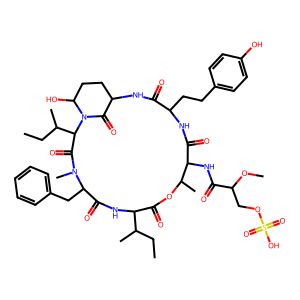

____________________________retival #3, cosine similarity: 0.7392309308052063_____________________________
retrived FP [0, 1, 2, 3, 4, 5, 6, 9, 14, 16, 17, 22, 23, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 57, 59, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 99, 100, 101, 102, 103, 109, 112, 113, 114, 117, 134, 135, 136, 137, 138, 141, 144, 147, 150, 151, 153, 154, 155, 156, 157, 158, 166, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 216, 219, 222, 224, 225, 235, 240, 241, 242, 243, 251, 259, 268, 297, 302, 309, 316, 317, 318, 319, 322, 323, 336, 337, 340, 341, 349, 350, 352, 354, 361, 362, 363, 367, 375, 377, 385, 386, 485, 496, 521, 573, 574, 575, 577, 578, 580, 592, 597, 598, 603, 612, 614, 617, 635, 636, 637, 674, 691, 755, 779, 798, 807, 816, 829, 833, 843, 848, 875, 887, 893, 897, 908, 918, 919, 920, 942, 948, 952, 973, 996, 1000, 1016, 1038, 1045, 1050, 1098, 1132, 1143, 1157, 1172, 1228, 1305, 1311, 1341, 1362, 1429, 1439, 1513, 1520, 1522, 1527, 1559, 161

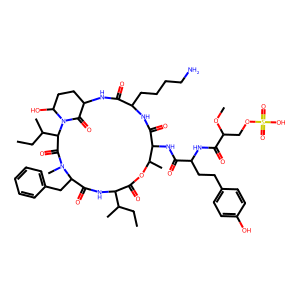

In [33]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=3)




new_compound_A




_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6760917306)



____________________________retival #1, retrival cosine similarity to prediction: 0.712273120880127_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6645684838)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name ['(R)-N-((2S,5S,8S,11R,12S,15S,18S,21R)-5-Benzyl-2,8-Di-Sec-Butyl-15-(3-Guanidinopropyl)-21-Methoxy-4,11-Dimethyl-3,6,9,13,16,22-Hexaoxo-10-Oxa-1,4,7,14,17-Pentaazabicyclo[16.3.1]Docosan-12-Yl)-2,3-Dihydroxypropanamide', '45379634']


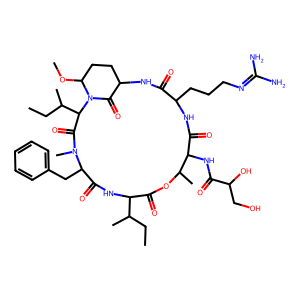

____________________________retival #2, retrival cosine similarity to prediction: 0.6942073702812195_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6634541154)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name ['45379633', '(R)-N-((2S,5S,8S,11R,12S,15S,18S,21R)-5-Benzyl-2,8-Di-Sec-Butyl-15-(3-Guanidinopropyl)-21-Hydroxy-4,11-Dimethyl-3,6,9,13,16,22-Hexaoxo-10-Oxa-1,4,7,14,17-Pentaazabicyclo[16.3.1]Docosan-12-Yl)-2,3-Dihydroxypropanamide']


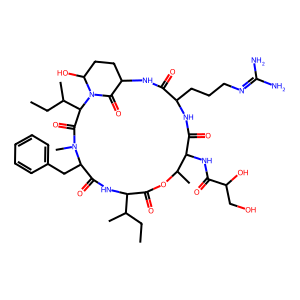

____________________________retival #3, retrival cosine similarity to prediction: 0.6925491094589233_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6731618643)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(CO)OS(=O)(=O)O)C(C)OC1=O
Name ['(R)-1-((2S,5S,8S,11R,12S,15S,18S,21R)-5-Benzyl-2,8-Di-Sec-Butyl-15-(3-Guanidinopropyl)-21-Methoxy-4,11-Dimethyl-3,6,9,13,16,22-Hexaoxo-10-Oxa-1,4,7,14,17-Pentaazabicyclo[16.3.1]Docosan-12-Ylamino)-3-Hydroxy-1-Oxopropan-2-Yl Hydrogen Sulfate', '45379736']


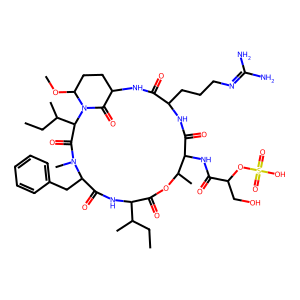

In [34]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=3, ground_truth_FP=newCompoundA_FP)




new_compound_B1




_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7176302671432495_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name ['kahalalide U']


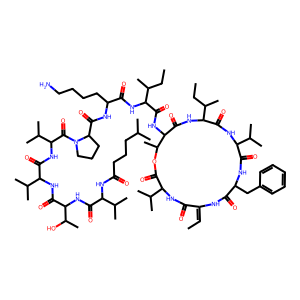

____________________________retival #2, retrival cosine similarity to prediction: 0.7170631289482117_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name ['9898671', 'kahalalide F', '(2R)-N-[(2S)-5-Amino-1-[[(2R,3S)-1-[[(3S,6Z,9S,12R,15R,18R,19R)-9-Benzyl-15-[(2S)-Butan-2-Yl]-6-Ethylidene-19-Methyl-2,5,8,11,14,17-Hexaoxo-3,12-Di(Propan-2-Yl)-1-Oxa-4,7,10,13,16-Pentazacyclononadec-18-Yl]Amino]-3-Methyl-1-Oxopentan-2-Yl]Amino]-1-Oxopentan-2-Yl]-1-[(2R)-2-[[(2S)-2-[[(2S,3R)-3-Hydroxy-2-[[(2R)-3-Methyl-2-(5-Methylhexanoylamino)Butanoyl]Amino]Butanoyl]Amino]-3-Methylbutanoyl]Amino]-3-Methylbutanoyl]Pyrrolidine-2-Carboxamide', 'Kahalalide F']


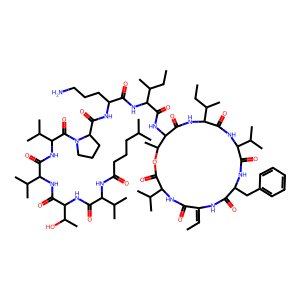

____________________________retival #3, retrival cosine similarity to prediction: 0.7151679992675781_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name ['kahalalide T']


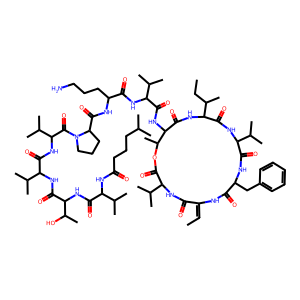

In [35]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=3)




new_compound_B2




_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7562535405158997_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name ['xentrivalpeptide D']


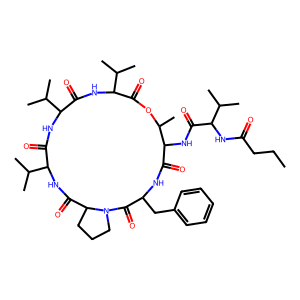

____________________________retival #2, retrival cosine similarity to prediction: 0.7486770749092102_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name ['1401343-49-4']


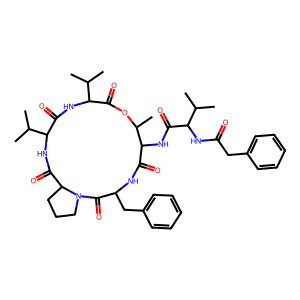

____________________________retival #3, retrival cosine similarity to prediction: 0.7486770749092102_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name ['XENTRIVALPEPTIDE A']


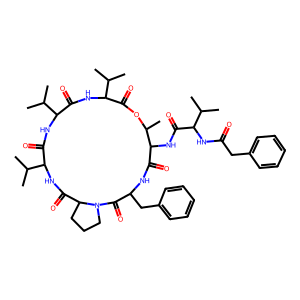

____________________________retival #4, retrival cosine similarity to prediction: 0.7380786538124084_____________________________
SMILES: CC(C)CC1NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C2CCCN2C1=O
Name ['Xentrivalpeptide L']


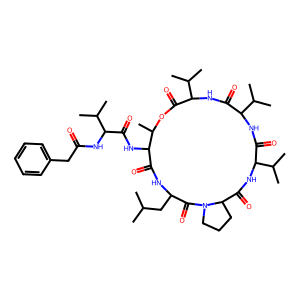

____________________________retival #5, retrival cosine similarity to prediction: 0.7194482088088989_____________________________
SMILES: CCC(C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)NC(=O)C1CCCN1C(=O)C1=CNC(C(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)N1)C(=O)O
Name ["1-{[(6S,8E,11aS,17S,20S,22aS)-17-Benzyl-6,20-diisopropyl-5,11,16,19,22-pentaoxo-2,3,6,7,10,11,11a,12,13,14,16,17,18,19,20,21,22,22a-octadecahydro-1H,5H-dipyrrolo[1,2-a:1',2'-j][1,4,7,10,13,16]hexaazac\r\nyclooctadecin-9-yl]carbonyl}-L-prolyl-L-leucyl-L-phenylalanyl-L-isoleucine"]


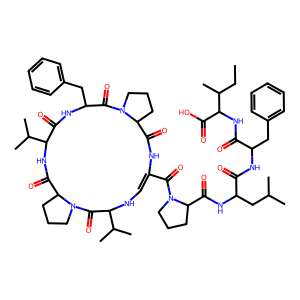

In [36]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5)